# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs
## Part : Monotone numerical schemes
## Chapter : Advection and diffusion, in one dimension

We illustrate discretization of time dependent partial differential equations in dimension one: advection and diffusion (non-divergence form), whose PDE formulation read 
$$
    \frac {\partial u}{\partial t} = v(t,x) \frac {\partial u}{\partial x} 
    \quad \text{and} \quad
    \frac {\partial u}{\partial t} = v(t,x) \frac {\partial^2 u}{\partial x^2}.
$$

**Disclaimer.** This notebook does *not* contain original research. It is limited to elementary examples, and may serve as a gentle introduction to (some of) the numerical tools and techniques related to time discretization.
My original research is rather devoted to the *spatial discretization* of PDE operators, which is irrelevant in here in dimension one. Examples in dimension two and higher, involving non-trivial geometrical constructions, will be presented in subsequent notebooks.

**Related.** The discretization of time dependent *divergence* form PDEs is discussed [here](../Notebooks_Div/Time1D_Div.ipynb).

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Advection](#1.-Advection)
    * [1.1 Upwind scheme, for a positive velocity](#1.1-Upwind-scheme,-for-a-positive-velocity)
      * [1.1.1 Numerical examples](#1.1.1-Numerical-examples)
      * [1.1.2 Stability analysis](#1.1.2-Stability-analysis)
    * [1.2 Upwind scheme, for a sign changing velocity](#1.2-Upwind-scheme,-for-a-sign-changing-velocity)
    * [1.3 Lax-Friedrichs scheme](#1.3-Lax-Friedrichs-scheme)
      * [1.3.1 Numerical examples](#1.3.1-Numerical-examples)
      * [1.3.1 Stability analysis](#1.3.1-Stability-analysis)
    * [1.4 Implicit scheme](#1.4-Implicit-scheme)
  * [2. Diffusion](#2.-Diffusion)
    * [2.1 Explicit scheme](#2.1-Explicit-scheme)
    * [2.2 Implicit scheme](#2.2-Implicit-scheme)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Time1D_NonDiv','NonDiv'))

In [4]:
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd.Plotting import animation_curve

In [5]:
import numpy as np
import scipy.sparse
from itertools import accumulate
import matplotlib.pyplot as plt
from matplotlib import rc; rc('animation', html='html5') # Web display

Some utility functions

In [6]:
def reload_packages():
    import importlib
    fd = importlib.reload(sys.modules['agd.FiniteDifferences'])
    ad = importlib.reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()

In [7]:
#from itertools import accumulate # Accumulate with initial value only exists in Python >= 3.8
def accumulate(iterable, func, initial):
    yield initial
    for element in iterable:
        initial = func(initial, element)
        yield initial

## 1. Advection

The advection equation governs the (non-conservative) transportation of a quantity $u$ at a given velocity $v$. The PDE formulation reads
$$
    \partial_t u = v \cdot \nabla u,
$$
for all $t>0$, $x \in \Omega$. The vector field $v : \Omega \to R^d$ is given, where $\Omega \subset R^d$.
We complement this equation with an initial value $u(t=0,x) = u_0(x)$, and Dirichlet or periodic boundary conditions.

**Remark:** The advection equation has an explicit solution, namely 
$$
    u(t,x) := u_0(\phi_x(t)),
$$
where the flow $\phi$ of the vector field $v$ satisfies the ODE (ordinary differential equation)
$$
    \frac d {dt} \phi_x(t) = v(\phi_x(t)).
$$

We consider an advection equation over the time interval $T=[0,T_{\max}]$, and space domain $X=[0,1]$ equipped with periodic boundary conditions.

In [8]:
Tmax = 0.8

In [9]:
X,dx = np.linspace(0,1,100,endpoint=False,retstep=True)

Discontinous, continuous, and $C^1$ smooth boundary conditions are considered.

In [10]:
u_disc = 1.*(X>=0.5)*(X<=0.75)
u_cont = np.maximum(0.,(0.5-X)*(X-0.75)); u_cont/=np.max(u_cont)
u_smooth = u_cont**2

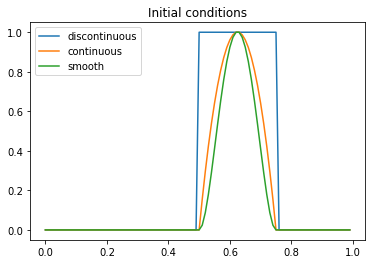

In [11]:
plt.title("Initial conditions")
plt.plot(X,u_disc, X,u_cont, X,u_smooth);
plt.legend(("discontinuous","continuous","smooth"));

We use a smooth velocity fields, which are constant, varying, or sign changing, depending on the spatial position. For simplicity, our velocity fields are time independent.

In [12]:
v_constant = 0.7
v_positive = 0.7  + 0.4*np.sin(2.*np.pi*X)
v_signed   = 0.25 + 0.4*np.sin(2.*np.pi*X)

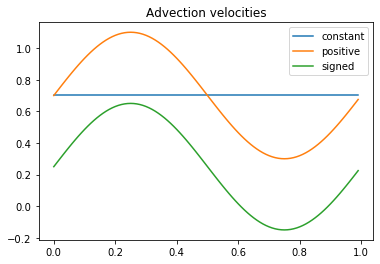

In [13]:
plt.title("Advection velocities")
plt.plot(X,v_constant+np.zeros_like(X), X,v_positive, X,v_signed)
plt.legend(("constant","positive","signed"));

### 1.1 Upwind scheme, for a positive velocity

We discretize the equation using upwind finite differences from the point $(x,t)$. The discretized system of equations reads
$$
    \frac{u(t+\delta t,x)-u(t,x)} {\delta t} = v(t,x) \frac{u(t,x+\delta x)-u(t,x)} {\delta x}.
$$
It can be put in an explicit form
$$
    u(t+\delta t,x) = u(t,x) + \delta t\  v(t,x)\frac{u(t,x+\delta x)-u(t,x)} {\delta x},
$$

In [14]:
def AdvectionUpwindPositive(u,v,dx,dt):
    """Upwind scheme for one-dimensional advection with a positive velocity"""
    return u+dt*v*fd.DiffUpwind(u,(1,),dx,padding=None) # No padding = periodic boundary conditions

#### 1.1.1 Numerical examples
With a sufficiently time step, and a velocity with the correct sign, see the discussion below the numerical scheme is stable. Note that it suffers from significant numerical diffusion.

In [15]:
dt = 0.01
solution =np.array(list(accumulate(
    np.arange(0,Tmax,dt), # time interval
    initial=u_disc, # initial condition
    func=lambda u,t: AdvectionUpwindPositive(u,v_constant,dx,dt) # evolution rule
)))

In [16]:
animation_curve(X,solution)

Our scheme applies without modification to non-constant velocities.

In [17]:
dt = 0.008
solution =np.array(list(accumulate(
    np.arange(0,1/0.7,dt), 
    initial=u_disc, 
    func=lambda u,t: AdvectionUpwindPositive(u,v_positive,dx,dt) 
)))

In [18]:
animation_curve(X,solution)

#### 1.1.2 Stability analysis
The scheme can be rewritten as 
$$
    u(t+\delta t,x) =(1- \omega(t,x)) u(t,x)  +\omega(t,x) u(t,x+\delta x) 
$$
where 
$$
    \omega(t,x) := v(t,x) \frac{\delta t}{\delta x}
$$
As a result, it is stable, in the $L^\infty$ norm, provided $0 \leq \omega(t,x) \leq 1$ for all $t,x$. This assumption is known as the Courant-Friedrichs-Levy (CFL) condition, and can be rewriten as 
$$
    0 \leq v_{\min} \quad \text{ and } \quad v_{\max}\ \delta t \leq \delta x.
$$
for all $t,x$. 

In [19]:
def AdvectionUpwindPositive_CFL(v,dx):
    """Returns the largest time step such that the advection scheme is stable"""
    assert(np.min(v)>=0)
    return dx/np.max(v)

In [20]:
AdvectionUpwindPositive_CFL(v_constant,dx)

0.014285714285714287

As expected, this scheme is unstable, and the numerical solution diverges, if the *time step exceeds the boundary condition*, or if the *velocity as a negative sign*.

In [21]:
dt = 0.015 # excessive time step
solution =np.array(list(accumulate(
    np.arange(0,Tmax,dt), 
    initial=u_disc, 
    func=lambda u,t: AdvectionUpwindPositive(u,v_constant,dx,dt) 
)))
print("(Excessive dt) Extremal solution values at t=Tmax : ", np.min(solution), np.max(solution))

(Excessive dt) Extremal solution values at t=Tmax :  -22.32598124669861 23.325981246698618


In [22]:
dt = 0.01
solution =np.array(list(accumulate(
    np.arange(0,Tmax,dt), 
    initial=u_disc, 
    func=lambda u,t: AdvectionUpwindPositive(u, -v_constant, dx,dt) # incorrect sign
)))
print("(Wrong sign of velocity) Extremal solution values at t=Tmax : ", np.min(solution), np.max(solution))

(Wrong sign of velocity) Extremal solution values at t=Tmax :  -1.2820559447380729e+29 1.2820559342356734e+29


### 1.2 Upwind scheme, for a sign changing velocity

We discretize the equation using upwind finite differences from the point $(x,t)$. The discretized system of equations reads
$$
    \frac{u(t+\delta t,x)-u(t,x)} {\delta t} = |v(t,x)| \frac{u(t,x+s(t,x)\delta x)-u(t,x)} {\delta x}.
$$
where $s(t,x)$ is the sign of $v(t,x)$.

The implementation and stability analyses are straightforward extensions of the positive case.

In [23]:
def AdvectionUpwind(u,v,dx,dt):
    """Upwind scheme for one-dimensional advection"""
    offsets = np.sign(v).reshape(1,len(v)).astype(int)
    return u+dt*np.abs(v)*fd.DiffUpwind(u,offsets,dx,padding=None) 

In [24]:
def AdvectionUpwind_CFL(v,dx):
    """Returns the largest time step such that the advection scheme is stable"""
    return dx/np.max(np.abs(v))

In [25]:
AdvectionUpwind_CFL(v_signed,dx)

0.015384615384615384

The scheme now applies to velocity fields with arbirary sign.

In [26]:
dt = 0.01
solution =np.array(list(accumulate(
    np.arange(0,Tmax,dt), 
    initial=u_disc, 
    func=lambda u,t: AdvectionUpwind(u,v_signed,dx,dt)
)))

In [27]:
animation_curve(X,solution)

### 1.3 Lax-Friedrichs scheme

This scheme introduces some additional viscosity, with a vanishing as the grid scale decreases, and uses centered finite differences for the first derivative. The introduced viscosity compensates the instability of centered finite differences, and yields a stable scheme. 

The scheme is second order consistent with the equation
$$
    \frac {\partial u}{\partial t} = v(x,t) \frac {\partial u}{\partial x} + \frac{\delta x^2} {2 \delta t} \frac {\partial^2 u}{\partial x^2}.
$$
Note that $\delta t$ and $\delta x$ are typically chosen proportional, based on the CFL condition, and therefore $\delta_x^2 / 2 \delta t \to 0$ as the scale is refined.
The discretization reads:
$$
    \frac{u(t+\delta t,x)-u(t,x)} {\delta t} 
    = v(t,x) \frac{u(t,x+\delta x)-u(t,x-\delta x)} {2\delta x}
    + \frac{u(t,x+\delta x)-2u(x,t)+u(t,x-\delta x)} {2\delta t}
$$

In [28]:
def AdvectionLaxFriedrichs(u,v,dx,dt):
    """Lax-Friedrichs scheme for one-dimensional advection"""
    return u+dt*(
        v*fd.DiffCentered(u,(1,),dx,padding=None) # Centered finite difference for advection
        + (dx**2/(2*dt))*fd.Diff2(u,(1,),dx,padding=None) # Additional diffusion
    ) 

#### 1.3.1 Numerical examples

We illustrate the Lax-Friedrich scheme with a discontinuous initial condition, and a sign varying velocity.
The scheme is stable, and approximates well the continuous solution. However, it is also subject to an surprising staircasing effect, due to the fact that the even and odd indices evolve independently of each other.

In [29]:
dt = 0.01
solution =np.array(list(accumulate(
    np.arange(0,Tmax,dt), 
    initial=u_disc, 
    func=lambda u,t: AdvectionLaxFriedrichs(u,0.*v_signed,dx,dt)
)))

In [30]:
animation_curve(X,solution)

#### 1.3.1 Stability analysis

The scheme can be rewritten in the explicit form
$$
    u(t+\delta t,x) 
    = \frac 1 2 (1-v(t,x) \frac {\delta t}{\delta x}) u(t,x-\delta x)
    + \frac 1 2 (1+v(t,x) \frac {\delta t}{\delta x}) u(t,x-\delta x)
$$
and it is therefore stable under the CFL condition: for all $t,x$
$$
    |v(t,x)| \delta t \leq \delta x,
$$
which is the same as for the upwind advection scheme.

In [31]:
AdvectionLaxFriedrichs_CFL = AdvectionUpwind_CFL

In [32]:
AdvectionLaxFriedrichs_CFL(v_signed,dx)

0.015384615384615384

### 1.4 Implicit scheme

Implicit schemes involve solving an inverse problem at each step. This has a substantial numerical cost, but it comes with strong benefits in terms of stability.

We rewrite the upwind scheme implicitly, and obtain an unconditionally stable scheme, independently of the time step. Note that using an excessively large time step may still result in accuracy loss.
<!---
Implicit schemes are obtained by 
$$
    \frac{u(t+\delta t,x)-u(t,x)} {\delta t} = v(t,x) \frac{u(t+\delta t,x+\delta x)-u(t+\delta t,x)} {\delta x}.
$$

$$
    u(t,x) = u(t+\delta t,x) + \delta t \ v(t,x) \frac{u(t+\delta t,x+\delta x)-u(t+\delta t,x)} {\delta x}
$$
--->

In [33]:
def AdvectionImplicit(u,v,dx,dt):
    """Upwind scheme for one-dimensional advection with a positive velocity"""
    offsets = np.sign(v).reshape(1,len(v)).astype(int)
    return u-dt*np.abs(v)*fd.DiffUpwind(u,offsets,dx,padding=None) # Note the -v

In [34]:
u_ad = ad.Sparse.identity((len(X),))

In [35]:
dt = 0.05
solution =np.array(list(accumulate(
    np.arange(0,Tmax,dt), 
    initial=u_disc, 
    func=lambda u,t: (AdvectionImplicit(u_ad,v_signed,dx,dt) - u).solve()
)))

In [36]:
animation_curve(X,solution)

Since we are repeatedly solving a fixed linear system, with a constant matrix, it makes sense to pre-factor it.

In [37]:
dt = 0.05

# Factorise the jacobian matrix
step_ad = AdvectionImplicit(u_ad,v_signed,dx,dt)
jacobian = scipy.sparse.coo_matrix(step_ad.triplets()).tocsc()
solver = scipy.sparse.linalg.factorized(jacobian)

solution2 =np.array(list(accumulate(
    np.arange(0,Tmax,dt), 
    initial=u_disc, 
    func=lambda u,t: solver(u)
)))

In [38]:
assert ad.Optimization.norm_infinity(solution-solution2) < 1e-15

## 2. Diffusion

We illustrate the explicit and implicit discretisation of diffusion, in non-divergence form.
The PDE 
$$
    \frac {\partial u}{\partial t} = \mu(t,x) \frac {\partial^2 u}{\partial x^2}.
$$
is discretized with periodic boundary conditions, and a given initial condition. Note that the diffusion coefficient $\mu(t,x)$ must be non-negative.

In [39]:
mu_constant = 0.7
mu_varying  = 0.7  + 0.4*np.sin(2.*np.pi*X)

### 2.1 Explicit scheme

A finite difference discretization yields the following scheme, which is second order in space, and first order in time.
$$
    u(t+\delta t,x) = u(t,x) + 
    \delta t \mu(t,x) \frac {u(t,x+\delta x) - 2 u(t,x) + u(t,x-\delta x)}{\delta x^2}
$$

In [40]:
def DiffusionExplicit(u,mu,dx,dt):
    return u+dt*mu*fd.Diff2(u,(1,),dx,padding=None)

The stability analysis, in the $L^\infty$ norm, yields the CFL condition
$$
    \delta t\  \mu_{\max} \leq \delta x^2.
$$
Thus $\delta t$ scales quadratically with the spatial scale, which is a severe constraint, and implies a very large number of time steps.

In [41]:
def DiffusionExplicit_CFL(mu,dx):
    """Largest time step such that scheme remains stable"""
    assert np.min(mu)>=0.
    return dx**2/(2*np.max(mu))

In [42]:
DiffusionExplicit_CFL(mu_varying,dx)

4.545454545454545e-05

In [43]:
dt = 0.5*DiffusionExplicit_CFL(mu_varying,dx)
solution =np.array(list(accumulate(
    np.arange(0,0.2,dt), 
    initial=u_disc, 
    func=lambda u,t: DiffusionExplicit(u,mu_varying,dx,dt)
)))

In [44]:
print(f"Number of time steps: {len(solution)}")

Number of time steps: 8802


In [45]:
animation_curve(X,solution[::100])

### 2.2 Implicit scheme

The implicit scheme for (non-divergence form) diffusion reads:
$$
    u(t,x) = u(t+\delta t,x) -
    \delta t \mu(t,x) \frac {u(t+\delta t,x+\delta x) - 2 u(t+\delta t,x) + u(t+\delta t,x-\delta x)}{\delta x^2}.
$$
It is unconditionally stable, provided the diffusion coefficient $\mu$ is non-negative, hence arbitrary timesteps can be used.

In [46]:
def DiffusionImplicit(u,mu,dx,dt):
    return u-dt*mu*fd.Diff2(u,(1,),dx,padding=None)

We rely on sparse automatic differentiation to assemble the linear system, and solve it.

In [47]:
u_ad = ad.Sparse.identity((len(X),))

In [48]:
dt = 0.01
solution =np.array(list(accumulate(
    np.arange(0,0.2,dt), 
    initial=u_disc, 
    func=lambda u,t: (DiffusionImplicit(u_ad,mu_varying,dx,dt)-u).solve()
)))

In [49]:
animation_curve(X,solution)

Since the same linear system is solved repeatedly, it makes sense to factor it.

In [50]:
dt = 0.01

# Factorise the jacobian matrix
step_ad = DiffusionImplicit(u_ad,mu_varying,dx,dt)
jacobian = scipy.sparse.coo_matrix(step_ad.triplets()).tocsc()
solver = scipy.sparse.linalg.factorized(jacobian)

solution2 =np.array(list(accumulate(
    np.arange(0,0.2,dt), 
    initial=u_disc, 
    func=lambda u,t: solver(u)
)))

In [51]:
assert ad.Optimization.norm_infinity(solution-solution2) < 1e-14